In [1]:
import numpy as np
import pandas as pd
# %matplotlib qt
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import modelbase
from modelbase.ode import Simulator

from scipy import integrate

plt.style.use("./notebook.mplstyle")
print(modelbase.__version__)

1.3.5


In [2]:
%%capture
cd ..

In [3]:
from models import get_model


m = get_model()

par_orig = m.get_parameters()

def get_new_y0(s):
    return dict(s.get_results_df().iloc[-1])

In [4]:
y0 = {
    "PQ": 11.027139850905353,
    "PC": 1.8895071932002812,
    "Fd": 3.8690237263896705,
    "ATP": 1.620195002854852,
    "NADPH": 0.4882103700673736,
    "H": 0.0022147075094596015,
    "LHC": 0.8023074419510501,
    "Psbs": 0.9607146039898598,
    "Vx": 0.950783616933656,
    "PGA": 0.9913970817549008,
    "BPGA": 0.0005355311557548053,
    "GAP": 0.0062630116252017295,
    "DHAP": 0.13778623933075737,
    "FBP": 0.006126990841013743,
    "F6P": 0.31166103888161867,
    "G6P": 0.7168203893211117,
    "G1P": 0.041575582577936025,
    "SBP": 0.01311315151803723,
    "S7P": 0.15782894767619207,
    "E4P": 0.00732079113061801,
    "X5P": 0.022396849486562384,
    "R5P": 0.03751472214765548,
    "RUBP": 0.13153657267999222,
    "RU5P": 0.015005888732707041,
    "MDA": 5.85270097771621e-06,
    "ASC": 9.999994138785292,
    "H2O2": 3.4273920330125316e-06,
    "DHA": 8.513863740903352e-09,
    "GSH": 9.999999991725186,
    "GSSG": 4.137406632226743e-09,
    "TR_ox": 0.9,
    "E_inactive": 4.7368421052631575,
}

y0_1000 = {
    "PQ": 1.507789886702025,
    "PC": 3.953187158958296,
    "Fd": 1.1279937081043432,
    "ATP": 2.400518163834891,
    "NADPH": 0.7833511016622213,
    "H": 11.834462552026038,
    "LHC": 0.3057293990674661,
    "Psbs": 0.5000000000384304,
    "Vx": 0.09090909091242916,
    "PGA": 0.04883787233687633,
    "BPGA": 0.0002431280086079331,
    "GAP": 0.019630698252342628,
    "DHAP": 0.43187533951527735,
    "FBP": 0.06019389866167178,
    "F6P": 2.6879366796632724,
    "G6P": 6.1822543628081625,
    "G1P": 0.35857075303234864,
    "SBP": 1.1860893478540198,
    "S7P": 0.044187268369558365,
    "E4P": 0.2112592088267863,
    "X5P": 0.02098062469006194,
    "R5P": 0.035142545427180046,
    "RUBP": 0.37432944394392,
    "RU5P": 0.0140570180127999,
    "MDA": 0.009653405870311431,
    "ASC": 9.959784342928879,
    "H2O2": 0.0008037536118780133,
    "DHA": 0.030562251200941273,
    "GSH": 9.976204054020393,
    "GSSG": 0.011897972989793133,
        "TR_ox": 0.9,
    "E_inactive": 4.7368421052631575,
}

In [5]:
s = Simulator(m)
s.initialise(y0)
#s.initialise(y0_1000)


pfd=1000
#fcbb=4


#s.update_parameter("kMehler", 1.)

#s.update_parameter("fCBB", fcbb)
s.update_parameter("pfd", pfd)


t, y = s.simulate(5000)

In [6]:
def get_minmax(s,T_END):
    c = s.get_full_results_df()
    v = s.get_fluxes_df()
    
    cmin = c.loc[T_END*0.75:,:].min()
    cmax = c.loc[T_END*0.75:,:].max()
    vmin = v.loc[T_END*0.75:,:].min()
    vmax = v.loc[T_END*0.75:,:].max()
    
    return cmin, cmax, vmin, vmax

In [7]:
def get_avg(s, T_END):
    c = s.get_full_results_df()
    v = s.get_fluxes_df()
    
    vavg=pd.Series(
        integrate.trapezoid(
            v.loc[T_END*0.75:,:],x=v.loc[T_END*0.75:,:].index,axis=0
        ) / (T_END-v.loc[T_END*0.75:,:].index.min()),
        index=v.columns)

    cavg=pd.Series(
        integrate.trapezoid(
            c.loc[T_END*0.75:,:],x=c.loc[T_END*0.75:,:].index,axis=0
        ) / (T_END-v.loc[T_END*0.75:,:].index.min()),
        index=c.columns)

    return cavg.T, vavg.T

In [8]:
def par_scan_osc(s, par_name, par_values, y0_loop, T_END = 100000):
    cmin = {}
    cmax = {}
    vmin = {}
    vmax = {}
    cavg = {}
    vavg = {}
    for i, x in tqdm(enumerate(par_values), total=len(par_values)):
        s.initialise(y0_loop)
        s.update_parameter(par_name, x)
        try:
            t, y = s.simulate(T_END)
            #concentrations[x] = dict(s.get_full_results_df().iloc[-1])
            #fluxes[x] = dict(s.get_fluxes_df().iloc[-1])
            cmin[x], cmax[x], vmin[x], vmax[x] = get_minmax(s,T_END)
            cavg[x], vavg[x] = get_avg(s,T_END)
            y0_loop = get_new_y0(s)
        except:
            all_compounds = s.model.get_all_compounds()
            rate_names = s.model.get_rate_names()
            cmin[x] = dict(
                zip(all_compounds), np.full(len(all_compounds), np.nan)
            )
            cmax[x] = dict(
                zip(all_compounds), np.full(len(all_compounds), np.nan)
            )
            cavg[x] = dict(
                zip(all_compounds), np.full(len(all_compounds), np.nan)
            )
            vmin[x] = dict(zip(rate_names, np.full(len(rate_names), np.nan)))
            vmax[x] = dict(zip(rate_names, np.full(len(rate_names), np.nan)))
            vavg[x] = dict(zip(rate_names, np.full(len(rate_names), np.nan)))
    return pd.DataFrame(cmin).T, pd.DataFrame(cmax).T, pd.DataFrame(vmin).T, pd.DataFrame(vmax).T, pd.DataFrame(cavg).T, pd.DataFrame(vavg).T
#    return pd.DataFrame(cmin).T, pd.DataFrame(cmax).T, pd.DataFrame(vmin).T, pd.DataFrame(vmax).T

In [9]:
def par_scan(s, par_name, par_values, y0_loop, T_END = 100000):
    fluxes = {}
    concentrations = {}
    for i, x in tqdm(enumerate(par_values), total=len(par_values)):
        s.initialise(y0_loop)
        s.update_parameter(par_name, x)
        try:
            t, y = s.simulate(T_END)
            concentrations[x] = dict(s.get_full_results_df().iloc[-1])
            fluxes[x] = dict(s.get_fluxes_df().iloc[-1])
            # Model is sensitive to initial conditions, so set the last ones every loop
            y0_loop = get_new_y0(s)
        except:
            all_compounds = s.model.get_all_compounds()
            rate_names = s.model.get_rate_names()
            concentrations[x] = dict(
                zip(all_compounds), np.full(len(all_compounds), np.nan)
            )
            fluxes[x] = dict(zip(rate_names, np.full(len(rate_names), np.nan)))
    return pd.DataFrame(concentrations).T, pd.DataFrame(fluxes).T


In [10]:
def plot_avg_minmax(key,dfavg,dfmin,dfmax,ax,label,color,**kwargs):
    kw = kwargs
    if 'color' in kw:
        kw.pop('color')
    if 'label' in kw:
        kw.pop('color')
    dfavg[key].plot(ax=ax, color=color, label=label, **kw)
    if 'style' in kw:
        kw.pop('style')
    if 'linewidth' in kw:
        kw.pop('linewidth')
    dfmin[key].plot(ax=ax, style="--", color=color, label="_"+label, linewidth=1, **kw)
    dfmax[key].plot(ax=ax, style="--", color=color, label="_"+label, linewidth=1, **kw)

In [11]:
def make_PGRL_PETC_figure(dffa, dff1, dff2):
    fig, ax = plt.subplots(2, figsize=(12,8), sharex=True)
    ax1, ax2 = ax.ravel()

    plot_avg_minmax("vPS1", dffa, dff1, dff2, ax1, "rate through PS1", "C0")
    plot_avg_minmax("vPS2", (2*dffa), (2*dff1), (2*dff2), ax1, "LEF", "C1")
    plot_avg_minmax("vCyc", (2*dffa), (2*dff1), (2*dff2), ax1, "CEF", "C2")

    plot_avg_minmax("ATP_norm", dfca, dfc1, dfc2, ax2, "ATP", "C0")
    plot_avg_minmax("NADP_redoxstate", dfca, dfc1, dfc2, ax2, "NADPH", "C1")
    plot_avg_minmax("Fd_redoxstate", dfca, dfc1, dfc2, ax2, "Fd", "C2")
    plot_avg_minmax("PQ_redoxstate", dfca, dfc1, dfc2, ax2, "PQ", "C3")
    plot_avg_minmax("PC_redoxstate", dfca, dfc1, dfc2, ax2, "PC", "C4")

    ax1.set_ylabel("mmol e$^-$/mol Chl/s")
    ax1.set_title("electron flows and H$_2$O$_2$ production")

    #flux_log["vMehler"].plot(ax=ax2, label="Mehler")
    ax1b = ax1.twinx()
    plot_avg_minmax("H2O2", (1000*dfca), (1000*dfc1), (1000*dfc2), ax1b, "steady state H$_2$O$_2$ concentration", "red", linewidth=1)
    #(np.array([1000])*dfc1["H2O2"]).plot(ax=ax1b, color="red", style=":", label="steady state H$_2$O$_2$ concentration")
    #(np.array([1000])*dfc1["H2O2"]).plot(ax=ax1b, color="red", style=":", label="steady state H$_2$O$_2$ concentration")
    #(np.array([1000])*dfc2["H2O2"]).plot(ax=ax1b, color="red", style=":", label="_steady state H$_2$O$_2$ concentration")
    ax1b.tick_params(axis='y', labelcolor='red')
    ax1b.set_ylabel("H$_2$O$_2$/$\mu$M", color="red")
    #ax1b.set_ylim([0,5])

    ax2.set_ylabel("fraction of total pool")
    ax2.set_xlabel("log$_2$-fold change in PGR5 activity")
    ax2.set_title("redox and energy states")

    for ax in ax.ravel():
        ax.legend(bbox_to_anchor=(1.2, 1))
    ax1b.legend(bbox_to_anchor=(1.2, 0.8))
    fig.tight_layout()
    
    return fig, ax

In [12]:
def make_PGRL_CBB_figure(dffa,dff1,dff2):
    fig, ax1 = plt.subplots(figsize=(12,8))
    ax1.set_xlabel("log$_2$-fold change in PGR5 activity")

    plot_avg_minmax("vRuBisCO", dffa, dff1, dff2, ax1, "CO$_2$ fixation", "C0")
    plot_avg_minmax("vStarch", 6*dffa, 6*dff1, 6*dff2, ax1, "starch", "C1")
    plot_avg_minmax("vgap", 3*dffa, 3*dff1, 3*dff2, ax1, "GAP export", "C2")
    plot_avg_minmax("vdhap", 3*dffa, 3*dff1, 3*dff2, ax1, "DHAP export", "C3")
    plot_avg_minmax("vpga", 3*dffa, 3*dff1, 3*dff2, ax1, "PGA export", "C4")

    trtot = [pd.DataFrame({'triose':(df.loc[:,["vgap","vdhap","vpga"]]*np.array([3,3,3])).sum(1)}) for df in [dffa,dff1,dff2]]
    plot_avg_minmax("triose", trtot[0], trtot[1], trtot[2], ax1, "total triose export", "black")

    ax1.set_ylabel("flux/(C-mM/s)")
    ax1.legend()
    
    return fig, ax1

## varying cyclic electron flow

### first for low light, PPFD=100

In [13]:
s.update_parameter("pfd", 100)
s.initialise(y0)

In [14]:
NUM_SCANS = 100
MIN_LOG_F = -3.2
MAX_LOG_F = 3.2
xscale = np.linspace(MIN_LOG_F, MAX_LOG_F, NUM_SCANS)
kcyc_vals = par_orig["kcyc"]*(2**xscale)

#conc_petc_cyc, flux_petc_cyc = par_scan(s, "kcyc", kcyc_vals, y0, T_END = 2000)
#cmin, cmax, vmin, vmax = par_scan_osc(s, "kcyc", kcyc_vals, y0, T_END = 2000)
cmin, cmax, vmin, vmax, cavg, vavg = par_scan_osc(s, "kcyc", kcyc_vals, y0, T_END = 2000)

dfc1_low=cmin.set_index(xscale)
dfc2_low=cmax.set_index(xscale)
dff1_low=vmin.set_index(xscale)
dff2_low=vmax.set_index(xscale)
dfca_low=cavg.set_index(xscale)
dffa_low=vavg.set_index(xscale)

  0%|          | 0/100 [00:00<?, ?it/s]

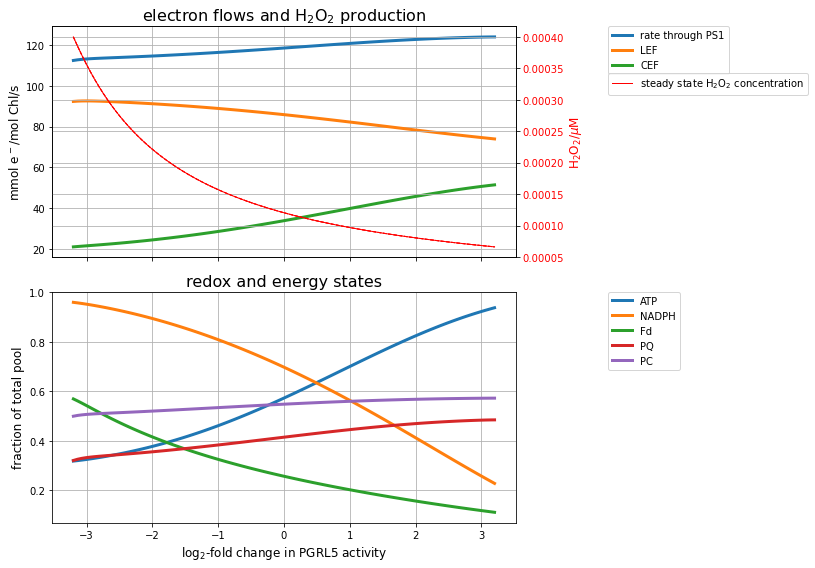

In [15]:
fig, ax = make_PGRL_PETC_figure(dffa_low,dff1_low,dff2_low)

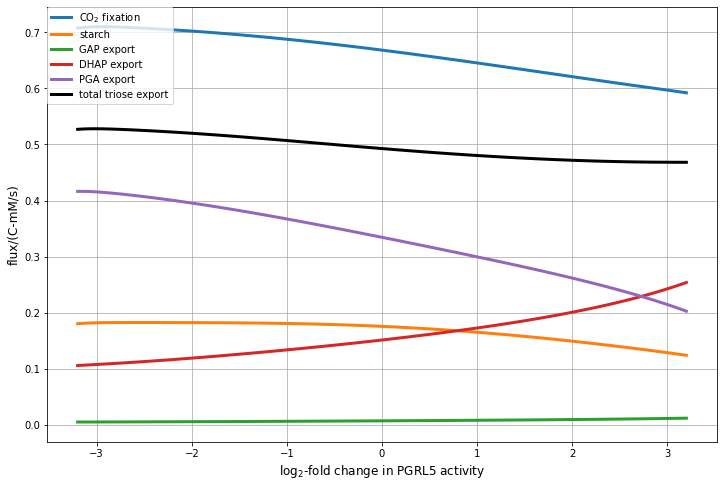

In [16]:
fig, ax = make_PGRL_CBB_figure(dffa_low,dff1_low,dff2_low)

### then for high light, PPFD=1000

In [18]:
s.update_parameter("pfd", 1000)
s.initialise(y0)

In [19]:
NUM_SCANS = 100
MIN_LOG_F = -3.2
MAX_LOG_F = 3.2
xscale = np.linspace(MIN_LOG_F, MAX_LOG_F, NUM_SCANS)
kcyc_vals = par_orig["kcyc"]*(2**xscale)

#conc_petc_cyc, flux_petc_cyc = par_scan(s, "kcyc", kcyc_vals, y0, T_END = 2000)
#cmin, cmax, vmin, vmax = par_scan_osc(s, "kcyc", kcyc_vals, y0, T_END = 2000)
cmin, cmax, vmin, vmax, cavg, vavg = par_scan_osc(s, "kcyc", kcyc_vals, y0, T_END = 2000)

dfc1=cmin.set_index(xscale)
dfc2=cmax.set_index(xscale)
dff1=vmin.set_index(xscale)
dff2=vmax.set_index(xscale)
dfca=cavg.set_index(xscale)
dffa=vavg.set_index(xscale)

  0%|          | 0/100 [00:00<?, ?it/s]

## Figure 5

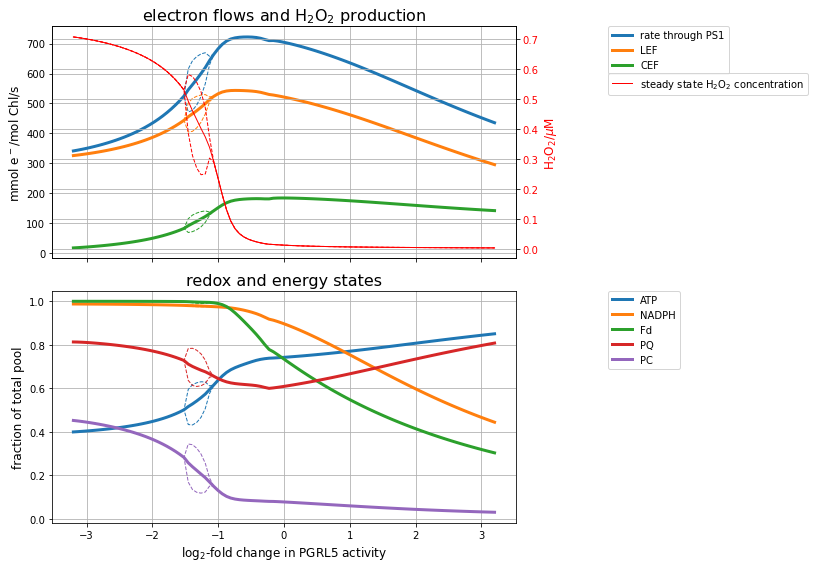

In [21]:
fig, ax = make_PGRL_PETC_figure(dffa,dff1,dff2)

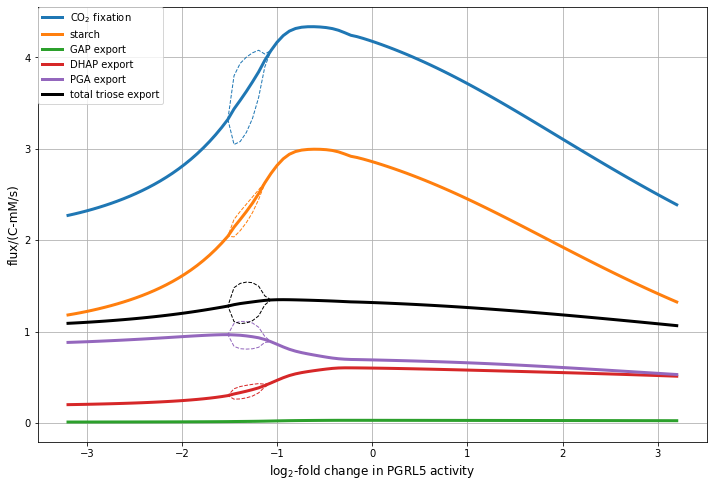

In [22]:
fig, ax = make_PGRL_CBB_figure(dffa,dff1,dff2)

In [ ]:
fig, ax1 = plt.subplots()
dff1["vMehler"].plot(ax=ax1,color="C0",label="Mehler")
dff2["vMehler"].plot(ax=ax1,color="C0",label="_Mehler")
dffa["vMehler"].plot(ax=ax1,color="C0",style="--",label="_Mehler")
ax1.set_xlabel("log$_2$-fold change of PGR5")
ax1.set_ylabel("mmol e$^-$/mol Chl/s")
ax1.legend(loc="upper right")

In [ ]:
%store cmin cmax vmin vmax cavg vavg

#### Now established: there are oscillations for certain values of k$_\mathrm{cyc}$
Therefore a "bifurcation" plot could be presented, or simply the average

Surface plots

In [ ]:
s.initialise(y0)
s.update_parameter('kMehler', 1)
#s.update_parameter('fCBB', fcbb)
s.update_parameter('pfd', 100)
#original_kcat_dhar=142
#original_kcat_mdar= 1080000 / (60 * 60)

#s.update_parameter('kcat_DHAR', original_kcat_dhar*10)
#s.update_parameter('kcatMDAR', original_kcat_mdar*10)
s.simulate(2000)
y0=dict(s.get_results_df().iloc[-1,:])

pfd_room=np.linspace(50.,1000,7)
#cyc1=np.linspace(0.1,1,4)
#cyc2=np.linspace(1,10,8)
#cyc_room=np.linspace(0.1,10,8)
cyc_room=np.geomspace(0.1, 10, 7)

surface_mdar=[]
surface_ps1=[]
surface_ps2=[]
surface_fd=[]
surface_ph=[]





for i in pfd_room:
    print('pfd: ',i)
    res_mdar=[]
    res_ps1=[]
    res_ps2=[]
    res_fd=[]
    res_ph=[]


    for j in cyc_room:
        print('cyc: ',j)
        y0=dict(s.get_results_df().iloc[-1,:])
        s.update_parameter('pfd', i)
        s.update_parameter('kcyc', j)
#        s.simulate_to_steady_state(atol=1e-14,rtol=1e-14)
        s.simulate_to_steady_state()


        loop_res=s.get_full_results_dict()
        fluxes=s.get_fluxes_dict()
        res_mdar.append(fluxes['vMDAreduct'][-1])
        res_ps1.append(fluxes['vPS1'][-1])
        res_ps2.append(fluxes['vPS2'][-1])
        res_fd.append( ((loop_res['Fd'][-1])/s.model.parameters['Fdtot']) )
        res_ph.append(loop_res['pH'][-1])


    surface_mdar.append(res_mdar)
    surface_ps1.append(res_ps1)
    surface_ps2.append(res_ps2)
    surface_fd.append(res_fd)
    surface_ph.append(res_ph)



In [ ]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')
X,Y = np.meshgrid(cyc_room,pfd_room)
ax.plot_surface(X, Y, np.array(surface_mdar),cmap='RdYlBu_r', edgecolor='none')
#ax.set_title('Cyclic electron flux over Mehler activity and light intensity')
ax.set_xlabel('kCyc')
ax.set_ylabel('PFD')
ax.set_zlabel('vMDAreduct')



import matplotlib.cm as cm
am = cm.ScalarMappable(cmap=cm.RdYlBu_r)
am.set_array(np.array(surface_mdar))
fig.colorbar(am,ax=ax)
plt.show()

In [ ]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')
X,Y = np.meshgrid(cyc_room,pfd_room)
ax.plot_surface(X, Y, np.array(surface_ps1),cmap='RdYlBu_r', edgecolor='none')
#ax.set_title('Cyclic electron flux over Mehler activity and light intensity')
ax.set_xlabel('kCyc')
ax.set_ylabel('PFD')
ax.set_zlabel('vPS1')



import matplotlib.cm as cm
am = cm.ScalarMappable(cmap=cm.RdYlBu_r)
am.set_array(np.array(surface_ps1))
fig.colorbar(am,ax=ax)
plt.show()

In [ ]:
LEF_array=np.array([2])*np.array(surface_ps2)






from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')
X,Y = np.meshgrid(cyc_room,pfd_room)
ax.plot_surface(np.log2(X), Y, LEF_array,cmap='RdYlBu_r', edgecolor='none')
#ax.set_title('Cyclic electron flux over Mehler activity and light intensity')
ax.set_xlabel('log$_2$ of kCyc')
ax.set_ylabel('PFD')
ax.set_zlabel('LEF Flux (e$^-$mmol/mol Chl/s)')



import matplotlib.cm as cm
am = cm.ScalarMappable(cmap=cm.RdYlBu_r)
am.set_array(LEF_array)
fig.colorbar(am,ax=ax)
plt.show()

In [ ]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')
X,Y = np.meshgrid(cyc_room,pfd_room)
ax.plot_surface(X, Y, np.array(surface_fd),cmap='RdYlBu_r', edgecolor='none')
#ax.set_title('Cyclic electron flux over Mehler activity and light intensity')
ax.set_xlabel('kCyc')
ax.set_ylabel('PFD')
ax.set_zlabel('Fd')



import matplotlib.cm as cm
am = cm.ScalarMappable(cmap=cm.RdYlBu_r)
am.set_array(np.array(surface_fd))
fig.colorbar(am,ax=ax)
plt.show()

In [ ]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')
X,Y = np.meshgrid(cyc_room,pfd_room)
ax.plot_surface(X, Y, np.array(surface_ph),cmap='RdYlBu_r', edgecolor='none')
#ax.set_title('Cyclic electron flux over Mehler activity and light intensity')
ax.set_xlabel('kCyc')
ax.set_ylabel('PFD')
ax.set_zlabel('pH')



import matplotlib.cm as cm
am = cm.ScalarMappable(cmap=cm.RdYlBu_r)
am.set_array(np.array(surface_ph))
fig.colorbar(am,ax=ax)
plt.show()

In [ ]:
surface_ph

Steady state analysis, look at redox carriers

surface plot with ps1 ps2

steady state analysis with oxygen concentration


In [ ]:
s.model.parameters['Fdtot']

Here, we simulate the dependency of the system on PFD and oxygen concentration

-Representative Variables statt PGA Fd rein tun, und poolkonzentrationen 0-1 schicken
-log2 x achse versuchen für parameters
-FCC weiß und rot blau andersrum
-Surface plot mit pH auslesen

### Investigation of the oscillations that appear in the parameter range around k$_\textrm{cyc}$=0.38..0.42

In [24]:
s.initialise(y0)
s.update_parameter("kcyc", 0.3865)
t, y = s.simulate(2000)
s.update_parameter("kcyc", par_orig["kcyc"])

In [ ]:
v = s.get_fluxes_df()
c = s.get_full_results_df()

In [ ]:
v["vMehler"].plot()

In [ ]:
v.loc[450:700,["vMehler"]].plot()

In [ ]:
c.loc[450:700,["Fd_redoxstate","NADP_redoxstate"]].plot()

In [ ]:
print("min:",c.loc[1500:,["Fd_redoxstate"]].min(0),", max:",c.loc[1500:,["Fd_redoxstate"]].max(0))

In [ ]:
s.initialise(y0)
s.update_parameter("kcyc", 0.119)
t, y = s.simulate(2000)

In [ ]:
cavg,vavg=get_avg(s,2000)

In [ ]:
vavg["vMehler"]

In [ ]:
cmin,cmax,vmin,vmax=get_minmax(s,2000)

In [ ]:
vmin["vMehler"]

In [ ]:
v=s.get_fluxes_df()

In [ ]:
v.loc[1500:,:].index.min()

In [ ]:
i=integrate.trapezoid(v.loc[1500:,"vMehler"],x=v.loc[1500:,:].index)

In [ ]:
i/(2000-v.loc[1500:,:].index.min())